# SN Explosion Boosted Dark Matter Preliminary Studies
Based on [arXiv:2206.06864](https://arxiv.org/abs/2206.06864)

In [13]:
import math
import numpy as np
import mpmath
import matplotlib.pyplot as mplot
from scipy.optimize import minimize

In [19]:
# Global parameters
snLuminosity = 1.87E58 # in MeV/s
nuFlavorId = [12,-12,14,-14,16,-16] #PDG ID
nuFluxAveEnergy = [11,16,25,25,25,25] # average energy for nu flux
nuFluxEta = [3,3,3,3,3,3] # pinching
dmNumberDensityPars_LMC = [3, 68, 31.9] # n, rho_s MeV/cm3, r_s kpc
cLight = 0.0003066 #kpc/year #3.0E8 #m/s
cLightInCmpS = 3.0E10 #cm/s
snDuration = 10.0 # seconds
snDistance = 50 # kpc
dmNuXscn = 1.0E-35 #cm-2 

In [86]:
# Number density/Flux Functions 

#Supernova Neutrino Energy Distribution
# Fermi-Dirac with pinching
# Flavor in PDG ID, energy in MeV
def normSnFlux(flavor, energy):
    index = nuFlavorId.index(flavor)
    aveEnergy = nuFluxAveEnergy[index]
    eta = nuFluxEta[index]
    
    temperature = aveEnergy/3.99
    normFactor = -2. * mpmath.polylog(3,-math.exp(eta)) # Integral done by wolfram alpha -2*Li_3(-e^eta)
    normFlux = 1./(normFactor *  pow(temperature,3) ) * pow(energy,2)/(math.exp( energy/temperature - eta) + 1)
    return normFlux

# Supernova Neutrino Number Density
# Energy in MeV, distance in kpc
# Output in nu/MeV/cm2/s: This is flux despite the name
# For number density, multiply by snDuration/snDuration*c (aka divide by c): This is # density at the neutrino shell
def snTotalNuDensity(energy, distance):
    totalNuDensity = 0
    distance = distance * 3.086E21 # now in centi-meters
    for flavor in nuFlavorId:
        totalNuDensity = totalNuDensity + normSnFlux(flavor, energy) / nuFluxAveEnergy[nuFlavorId.index(flavor)]
    # Square energy term is already implemented in the flux,
    #totalNuDensity = totalNuDensity * (snLuminosity/6.) / ( 4 * math.pi * pow(distance,2) ) * pow(energy,2)
    totalNuDensity = totalNuDensity * (snLuminosity/6.) / ( 4 * math.pi * pow(distance,2) )
    if(energy>999.):
        totalNuDensity = 0
    return totalNuDensity


# Dark matter density
# distance in kpc and mDark in MeV
# output in 1/cm3
def dmNumberDensity(distance, mDark):
    distanceRatio = distance/dmNumberDensityPars_LMC[2]
    numberDensity = (dmNumberDensityPars_LMC[1] / mDark)
    numberDensity = numberDensity / ( distanceRatio * pow( (1+distanceRatio), dmNumberDensityPars_LMC[0]) )
    return numberDensity

In [118]:
# Kinematic Functions

# Theta (CM angle) in terms of alpha (lab angle)
# nuEnergy and mDark in MeV
def cmTheta(nuEnergy, mDark, alpha):
    gamma = (nuEnergy + mDark) / math.sqrt( mDark * (2*nuEnergy + mDark) )
    theta = 2*math.atan( gamma * math.tan(alpha) )
    return theta

# Angular Distribution
def fAngular(nuEnergy, mDark, alpha):
    gamma = (nuEnergy + mDark) / math.sqrt( mDark * (2*nuEnergy + mDark) )
    angular = pow(gamma,3) / ( math.pi * pow(math.cos(alpha),3) * pow( 1+pow(gamma*math.tan(alpha), 2), 2) )
    return angular
    
# DM Kinetic Energy
def dmKinetic(nuEnergy, mDark, alpha):
    theta = cmTheta(nuEnergy, mDark, alpha)
    kineticEnergy = pow(nuEnergy,2)/( nuEnergy + mDark/2. ) * ( (1 + math.cos(theta)) / 2. )
    return kineticEnergy

def nuEnergyFromDmKineticInverse(dmKineticTrue, mDark, alpha):
    nuEneArray = np.arange(0,200,1)
    nuEneArray = np.append(nuEneArray, np.arange(210,1000,10))
    #nuEneArray = np.append(nuEneArray, np.arange(1100,10000,100))
    #nSteps = 1000
    #minEne = dmKineticTrue
    #maxEne = 2*dmKineticTrue*pow((1+math.tan(alpha)),2)
    #nuEneArray = np.linspace(minEne,maxEne,nSteps)
    dmKineticArray = [ dmKinetic(e,mDark,alpha) for e in nuEneArray ]
    return np.interp(dmKineticTrue, dmKineticArray, nuEneArray)

#def nuEnergyPerFixed
def nuEnergyFromDmKinetic(dmKinetic, mDark, alpha):
    num = +mDark/math.cos(alpha)*math.sqrt( dmKinetic*(2*mDark+dmKinetic) ) + \
           mDark*dmKinetic*(1+pow(math.tan(alpha),2))
    denom = 2*mDark - dmKinetic*pow(math.tan(alpha),2)
    nuEnergy = num/denom
    if(nuEnergy<0):
        num = -mDark/math.cos(alpha)*math.sqrt( dmKinetic*(2*mDark+dmKinetic) ) + \
               mDark*dmKinetic*(1+pow(math.tan(alpha),2))
        nuEnergy = num/denom
    return nuEnergy

# BDM velocity over speed of light
def dmVelocityOverC(dmKinetic, mDark):
    dmVelo = math.sqrt(dmKinetic*(2*mDark+dmKinetic)) / ( mDark + dmKinetic )
    return dmVelo

def d_nuEne_d_dmKinetic(dmKineticTrue, mDark, alpha):
    step = 0.01 #MeV
    #nuEneArray = np.arange(0,200,0.05)
    nuEneArray = np.arange(0,200,1)
    nuEneArray = np.append(nuEneArray, np.arange(210,1000,10))
    dmKineticArray = [ dmKinetic(e,mDark,alpha) for e in nuEneArray ]
    eneLow = np.interp(dmKineticTrue-step/2., dmKineticArray, nuEneArray)
    eneHigh = np.interp(dmKineticTrue+step/2., dmKineticArray, nuEneArray)
    return (eneHigh-eneLow)/step

def bdmEmissivity(radius, dmKinetic, alpha, mDark, dmNuXscn):
    nuEnergy = nuEnergyFromDmKineticInverse(dmKinetic, mDark, alpha)
    emissivity = dmNuXscn * dmNumberDensity(radius, mDark) * snTotalNuDensity(nuEnergy, radius) 
    emissivity = emissivity * d_nuEne_d_dmKinetic(dmKinetic, mDark, alpha) * dmVelocityOverC(dmKinetic, mDark)
    emissivity = emissivity * fAngular(nuEnergy, mDark, alpha)
    return emissivity

# Calculates r,l, alpha from observed theta, dmKinetic and timeDelay
# distances in kpc, mass energies in MeV, time in years, angles in radians
def geometryResults(theta, dmKinetic, timeDelay, mDark, snDistance):
    dmVelo = dmVelocityOverC(dmKinetic, mDark)
    # First solve for r (coefficients quadA*r^2 + 2*(quadBo2)*r + quadC*r = 0 )
    quadA = 1-pow(dmVelo,2)
    quadBo2 = dmVelo*cLight*timeDelay - 2*snDistance*math.cos(theta)*dmVelo
    quadC = 2*snDistance*math.cos(theta)*cLight*timeDelay*dmVelo - pow((cLight*timeDelay*dmVelo),2) - pow(snDistance,2)
    intRadius = (-quadBo2 + math.sqrt( pow(quadBo2,2) - quadA*quadC ) ) / quadA
    dmTravelDistance = (cLight*timeDelay - intRadius)*dmVelo
    alpha = math.atan( dmTravelDistance*math.sin(theta) / ( snDistance-dmTravelDistance*math.cos(theta) ) ) + theta
    jacobian = cLightInCmpS / ( ( dmTravelDistance - snDistance*math.cos(theta) )/ intRadius + 1/dmVelo ) # cm/s
    return intRadius, dmTravelDistance, alpha, jacobian

# calculate BDM flux given theta, dmKinetic, timeDelay, mDark, snDistance, and dmNuXscn
# This is BDM flux per dm KE per cos(theta) at given parameters
def bdmDoubleDiffFlux(theta, dmKinetic, timeDelay, mDark, snDistance, dmNuXscn):
    [intRadius, dmTravelDistance, alpha, jacobian] = \
        geometryResults(theta, dmKinetic, timeDelay, mDark, snDistance)
    emissivity = bdmEmissivity(intRadius, dmKinetic, alpha, mDark, dmNuXscn)
    diffFlux = 2*math.pi*snDuration*jacobian*emissivity
    return diffFlux

# Flux per MeV
def bdmFlux(dmKinetic, timeDelay, mDark, snDistance, dmNuXscn):
    cosThetaStep = 0.01
    cosThetaArray = np.arange(0,1,cosThetaStep)
    thetaArray = np.arccos(cosThetaArray)
    diffFluxArray = [ bdmDoubleDiffFlux(theta, dmKinetic, timeDelay, mDark, snDistance, dmNuXscn) \
                     for theta in thetaArray ]
    angleIntFlux = np.trapz(diffFluxArray,dx=cosThetaStep)
    return angleIntFlux
    

2.68336574945017e-23


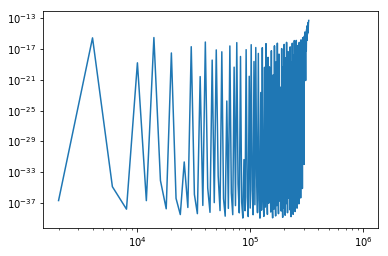

In [123]:
dmKineticX = 10
mDarkX = 0.001
timeDelayX = 10
print( bdmFlux(dmKineticX, timeDelayX, mDarkX, snDistance, dmNuXscn) )
timeDelayArray = np.arange(0,1000000,2000)
bdmFluxArray = [ bdmFlux(dmKineticX,time, mDarkX, snDistance, dmNuXscn) for time in timeDelayArray ]
mplot.plot(timeDelayArray, bdmFluxArray)
mplot.yscale('log')
mplot.xscale('log')
mplot.show()

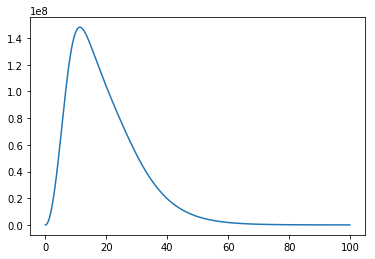

In [83]:
nuEnergy = np.arange(0,100,0.1)
nueFlux = [ snTotalNuDensity(e,50.0) for e in nuEnergy ]
mplot.plot(nuEnergy, nueFlux)
mplot.show()

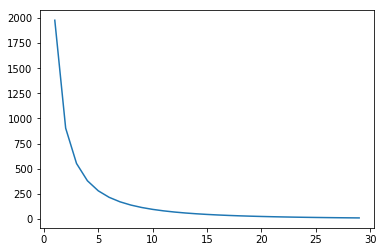

In [84]:
dmDistance = np.arange(1,30,1)
mDark = 1 #MeV
dmDensity = [ dmNumberDensity(d,mDark) for d in dmDistance ]
mplot.plot(dmDistance, dmDensity)
mplot.show()

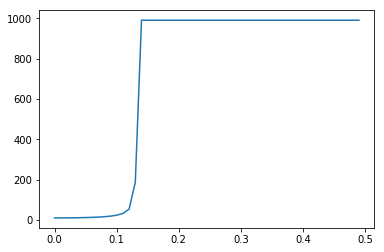

[10.477178423236515, 10.536974449569046, 10.720360432774612, 11.039693841262743, 11.521546095706698, 12.203015838126705, 13.152490353364751, 14.483912128037414, 16.390361036439604, 19.253843530741168, 23.908079028864773, 32.59595728855736, 53.99830189849886, 186.92248564586154, 990.0, 990.0, 990.0, 990.0, 990.0, 990.0, 990.0, 990.0, 990.0, 990.0, 990.0, 990.0, 990.0, 990.0, 990.0, 990.0, 990.0, 990.0, 990.0, 990.0, 990.0, 990.0, 990.0, 990.0, 990.0, 990.0, 990.0, 990.0, 990.0, 990.0, 990.0, 990.0, 990.0, 990.0, 990.0, 990.0]


In [52]:
mDark = 1
dmKineticX = 10
alphaRange = np.arange(0,0.5,0.01)
nuEneRange = [ nuEnergyFromDmKineticInverse(dmKineticX, mDark, a*math.pi) for a in alphaRange ]
mplot.plot(alphaRange,nuEneRange)
mplot.show()
print(nuEneRange)

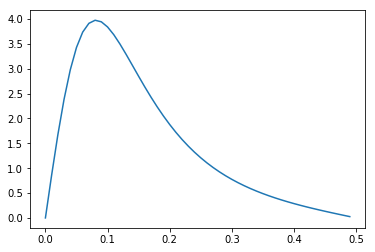

[0.0, 0.8603435054918749, 1.6701643457165285, 2.3861381403282733, 2.977489982631632, 3.428380746117444, 3.7372676440724155, 3.9140478450947294, 3.9761680881979578, 3.944770996650717, 3.84156440158571, 3.6866804647007743, 3.49748212541339, 3.2881135710051366, 3.0695502007418933, 2.849932168242596, 2.63502141313803, 2.428678742781853, 2.233303061749344, 2.050206550649824, 1.8799192209371636, 1.7224269929609002, 1.577352315086367, 1.4440877346590781, 1.3218923744058362, 1.2099599781762, 1.107465651567565, 1.0135969387537684, 0.927573580842611, 0.8486592335054101, 0.7761675750629856, 0.7094645826303599, 0.6479682592128314, 0.5911467258839755, 0.5385153216891748, 0.48963315615041186, 0.4440994165503118, 0.4015496301506348, 0.36165200924029556, 0.32410395624946864, 0.2886287710683433, 0.25497257873655416, 0.2229014795877412, 0.19219891339761405, 0.16266322240130202, 0.13410539400154467, 0.10634696171535393, 0.079218041785814, 0.0525554824815192, 0.026201103112872836]


In [71]:
mDark = 1
nuEnergy = 10
alphaRange = np.arange(0,0.5,0.01)
angularDistNormal = [ 2*math.pi*math.sin(a*math.pi)*fAngular( nuEnergy, mDark, a*math.pi) for a in alphaRange ]
mplot.plot(alphaRange,angularDistNormal)
mplot.show()
print(angularDistNormal)

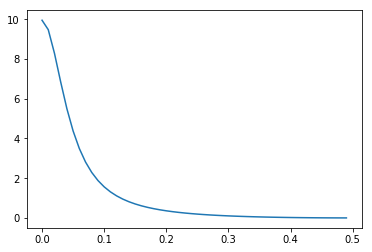

[9.950248756218905, 9.475322420884616, 8.28575367428996, 6.845771529312181, 5.497542734787294, 4.37733962194049, 3.495227445732832, 2.8141915902183956, 2.2896682800080317, 1.8831963976784136, 1.5650086298375474, 1.3130145958956603, 1.111050350160206, 0.9472984103376498, 0.8130692732802167, 0.7019157798626535, 0.6090041182560606, 0.5306700412857941, 0.4641052204105769, 0.4071342162996136, 0.3580545456621858, 0.3155208927633577, 0.2784604359387199, 0.24601029895283696, 0.21747088416157134, 0.1922707171697751, 0.16993971641218256, 0.1500886875204553, 0.132393459522233, 0.11658251341979087, 0.10242726092331308, 0.08973435080866593, 0.07833953886509401, 0.0681027727344151, 0.05890422758036806, 0.05064109114343163, 0.0432249434279522, 0.036579611351364595, 0.030639405241276764, 0.025347664312921472, 0.020655553805312987, 0.016521068474643442, 0.012908206503439256, 0.009786285225525914, 0.0071293758696909515, 0.004915839150237717, 0.0031279472547668355, 0.0017515808087226494, 0.00077599189539

In [81]:
mDark = 0.1
nuEnergy = 10
alphaRange = np.arange(0,0.5,0.01)
dmKineticRange = [ dmKinetic(nuEnergy, mDark, a*math.pi) for a in alphaRange ]
mplot.plot(alphaRange,dmKineticRange)
mplot.show()
print(dmKineticRange)

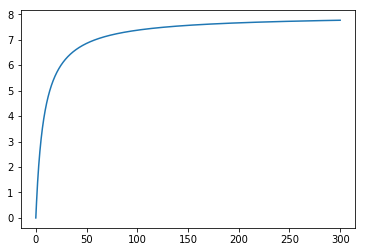

[0.0, 0.0016255489301310725, 0.0055705523003327486, 0.010959606616814133, 0.01730508143501356, 0.024313831228530924, 0.031799041151449499, 0.039636036458687546, 0.047738439106770912, 0.056044520400416825, 0.064509001333904803, 0.073097921865117862, 0.081785317742010852, 0.090551003151800577, 0.099379052447490693, 0.10825673665295167, 0.11717376337693146, 0.12612172373249428, 0.13509368334494942, 0.14408387547661569, 0.15308746771107895, 0.16210038241602201, 0.17111915705800371, 0.18014083441720261, 0.18916287549258903, 0.19818308980854688, 0.20719957919750515, 0.21621069211354721, 0.22521498624524627, 0.23421119772061416, 0.24319821558690349, 0.25217506054047512, 0.26114086710333523, 0.2700948686119431, 0.27903638451391971, 0.28796480956908643, 0.29687960462994556, 0.30578028873855484, 0.31466643232565061, 0.32353765133678314, 0.33239360214135993, 0.34123397710553527, 0.35005850073013989, 0.35886692627129979, 0.36765903277482959, 0.37643462246650627, 0.38519351844940586, 0.393935562666

In [101]:
mDark = 0.1
alpha=0.05*math.pi
nuEneRange = np.arange(0,300,0.01)
dmKineticRange = [ dmKinetic(e, mDark, alpha) for e in nuEneRange ]
mplot.plot(nuEneRange,dmKineticRange)
mplot.show()
print(dmKineticRange)

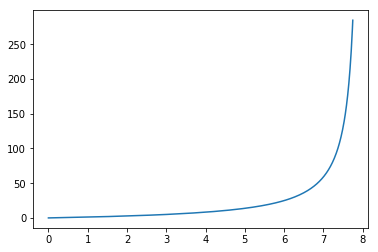

[0.0, 0.012017680671683453, 0.024035361343366906, 0.03605304201505036, 0.04807072268673381, 0.06008840335841727, 0.07210608403010071, 0.08412376470178418, 0.09614144537346762, 0.10815912604515107, 0.12017680671683453, 0.132194487388518, 0.14421216806020143, 0.1562298487318849, 0.16824752940356835, 0.18026521007525179, 0.19228289074693525, 0.2043005714186187, 0.21631825209030214, 0.2283359327619856, 0.24035361343366907, 0.2523712941053525, 0.264388974777036, 0.27640665544871945, 0.28842433612040286, 0.3004420167920863, 0.3124596974637698, 0.32447737813545324, 0.3364950588071367, 0.3485127394788201, 0.36053042015050357, 0.37254810082218703, 0.3845657814938705, 0.39658346216555396, 0.4086011428372374, 0.4206188235089209, 0.4326365041806043, 0.44465418485228775, 0.4566718655239712, 0.46868954619565467, 0.48070722686733813, 0.4927249075390216, 0.504742588210705, 0.5167602688823885, 0.528777949554072, 0.5407956302257554, 0.5528133108974389, 0.5648309915691223, 0.5768486722408057, 0.588866352

In [103]:
mDark = 0.1
alpha=0.05*math.pi
dmKineticRange = np.arange(0,7.76,0.01)
nuEneRange = [ nuEnergyFromDmKineticInverse(k, mDark, alpha) for k in dmKineticRange ]
mplot.plot(dmKineticRange,nuEneRange)
mplot.show()
print(nuEneRange)

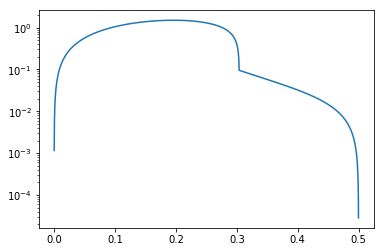

In [115]:
alphaRange = np.arange(0,0.5,0.0001)
mDark = 10
dmKineticX = 10
angularDist = [ 2*math.pi*math.sin(a*math.pi)*fAngular(nuEnergyFromDmKineticInverse(dmKineticX, mDark, a*math.pi), mDark, a*math.pi) for a in alphaRange ]
mplot.plot(alphaRange,angularDist)
mplot.yscale('log')
mplot.show()

### TEST CELLS BELOW

In [39]:
a = [1,2,3]
math.cos(math.pi/2)

6.123233995736766e-17

In [40]:
eta = 3.
a = -2. * mpmath.polylog(3,-math.exp(eta))
print 3^4

7


In [36]:
a=4
a*=2
print(a)
def x(a):
    return a*a, a*a*a
[a2,a3] = x(3)
a3
a = np.arange(0,2,1)
print(a)
print(2*a)
b = np.array([3,4])
print(b)
a = np.append(a,b)
print(a)
a = np.append(a,b)
print(a)

8
[0 1]
[0 2]
[3 4]
[0 1 3 4]
[0 1 3 4 3 4]


In [124]:
cosThetaStep = 0.01
cosThetaArray = np.arange(0,1,cosThetaStep)
thetaArray = np.arccos(cosThetaArray)
print(thetaArray)

[ 1.57079633  1.56079616  1.55079499  1.54079182  1.53078565  1.52077547
  1.51076027  1.50073903  1.49071075  1.48067438  1.47062891  1.46057328
  1.45050644  1.44042735  1.43033491  1.42022805  1.41010567  1.39996666
  1.38980988  1.37963418  1.36943841  1.35922137  1.34898186  1.33871864
  1.32843048  1.31811607  1.30777412  1.2974033   1.28700222  1.27656949
  1.26610367  1.25560329  1.24506684  1.23449275  1.22387943  1.21322522
  1.20252843  1.19178731  1.18100003  1.17016473  1.15927948  1.14834226
  1.13735101  1.12630355  1.11519765  1.10403099  1.09280113  1.08150555
  1.07014161  1.05870657  1.04719755  1.03561154  1.02394538  1.01219576
  1.00035922  0.98843209  0.97641053  0.96429047  0.95206764  0.93973749
  0.92729522  0.91473574  0.90205362  0.88924312  0.87629806  0.86321189
  0.84997757  0.83658754  0.82303369  0.80930727  0.79539883  0.78129812
  0.76699401  0.75247438  0.73772597  0.72273425  0.70748321  0.69195518
  0.67613051  0.65998733  0.64350111  0.62664421  0